In [1]:
import torch
from torchdrug import data, datasets
from Data import DataSet,Toxcity,rounder,ajout
from torchdrug import core, models, tasks, utils
smi="C1=CC=CC=C1"
def torchDrug(smi:str):
    dataset = DataSet("data_wassim_imputed_encoded.csv")
    Toxic = Toxcity("tox.csv")
    Tox = models.GIN(input_dim=Toxic.node_feature_dim,
                   hidden_dims=[256, 256, 256, 256,256,256],
                   short_cut=True, batch_norm=True, concat_hidden=True)
    taskT = tasks.PropertyPrediction(Tox, task=Toxic.tasks,
                                criterion="bce", metric=("auroc","auprc"))
    optimizerT= torch.optim.Adam(taskT.parameters(), lr=1e-3)
    solverT= core.Engine(taskT, Toxic, Toxic, Toxic, optimizerT,
                     gpus=[0], batch_size=1024)
    solverT.load("clintox_ginToxcity.pth")
    model = models.GIN(input_dim=dataset.node_feature_dim,
                   hidden_dims=[256, 256, 256, 256,256,256,256],
                   short_cut=True, batch_norm=True, concat_hidden=True)
    task = tasks.PropertyPrediction(model, task=dataset.tasks,
                                criterion="bce", metric=( "auprc"))
    optimizer = torch.optim.Adam(task.parameters(), lr=1e-3)
    solver = core.Engine(task, dataset,dataset, dataset, optimizer,
                     gpus=[0], batch_size=1024)
    solver.load("clintox_ginMULTI.pth")
    mol = data.Molecule.from_smiles(smi)
    xT=Toxic[:1]
    xT[0]['graph']=mol
    xM=dataset[:1]
    xM[0]['graph']=mol
    batchT= data.graph_collate(xT)
    batchT= utils.cuda(batchT)
    predT= torch.nn.functional.sigmoid(taskT.predict(batchT))
    batchM= data.graph_collate(xM)
    batchM= utils.cuda(batchM)
    predM= torch.nn.functional.sigmoid(task.predict(batchM))
    a0=predT.tolist()
    a1=predM.tolist()
    Toxicity=[]
    for i in a0 :
        if(i[0]>=0.5):
            Toxicity.append(1)
        else:
            Toxicity.append(0)
        
    Multi=rounder(a1)

    Multi=ajout(Multi,Toxicity)
    return Multi[0]



In [3]:
torchDrug(smi)

Constructing molecules from SMILES:  33%|███▎      | 39/118 [00:00<00:00, 389.03it/s]/home/sliti-wassim/anaconda3/envs/torchDrug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Au`
  warnings.warn("Unknown value `%s`" % x)
/home/sliti-wassim/anaconda3/envs/torchDrug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Co`
  warnings.warn("Unknown value `%s`" % x)
/home/sliti-wassim/anaconda3/envs/torchDrug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES:  74%|███████▎  | 87/118 [00:00<00:00, 438.81it/s]/home/sliti-wassim/anaconda3/envs/torchDrug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Hg`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES: 100%|██████████| 106/106 [00:00<00:00, 475.81it/s]

17:30:33   Preprocess training set
17:30:33   Load checkpoint from clintox_ginToxcity.pth
17:30:33   Preprocess training set
17:30:33   Load checkpoint from clintox_ginMULTI.pth


[0, 1, 1, 0]


Constructing molecules from SMILES:  38%|███▊      | 45/118 [00:00<00:00, 443.54it/s]/home/sliti-wassim/anaconda3/envs/torchDrug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Au`
  warnings.warn("Unknown value `%s`" % x)
/home/sliti-wassim/anaconda3/envs/torchDrug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Co`
  warnings.warn("Unknown value `%s`" % x)
/home/sliti-wassim/anaconda3/envs/torchDrug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES:  77%|███████▋  | 91/118 [00:00<00:00, 452.45it/s]/home/sliti-wassim/anaconda3/envs/torchDrug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Hg`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES: 100%|██████████| 106/106 [00:00<00:00, 485.58it/s]


In [4]:
lengths = [int(0.7 * len(dataset)), int(0.3 * len(dataset))]
lengths += [len(dataset) - sum(lengths)]
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, lengths)

In [5]:
lengths = [int(0.7 * len(Toxic)), int(0.3 * len(Toxic))]
lengths += [len(Toxic) - sum(lengths)]
train_setT, valid_setT, test_setT = torch.utils.data.random_split(Toxic, lengths)

16:31:49   Preprocess training set
16:31:50   Load checkpoint from clintox_ginToxcity.pth


In [7]:
from torchdrug import core, models, tasks, utils

model = models.GIN(input_dim=dataset.node_feature_dim,
                   hidden_dims=[256, 256, 256, 256,256,256,256],
                   short_cut=True, batch_norm=True, concat_hidden=True)
task = tasks.PropertyPrediction(model, task=dataset.tasks,
                                criterion="bce", metric=( "auprc"))

optimizer = torch.optim.Adam(task.parameters(), lr=1e-3)
solver = core.Engine(task, train_set, valid_set, test_set, optimizer,
                     gpus=[0], batch_size=1024)
solver.load("clintox_ginMULTI.pth")
solver.evaluate("valid")

16:31:52   Preprocess training set
16:31:52   Load checkpoint from clintox_ginMULTI.pth
16:31:52   Evaluate on valid
16:31:53   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
16:31:53   auprc [Activity_EC50]: 0.838787
16:31:53   auprc [Activity_EC90]: 0.936345
16:31:53   auprc [Activity_IC50]: 0.996298


{'auprc [Activity_IC50]': tensor(0.9963, device='cuda:0'),
 'auprc [Activity_EC50]': tensor(0.8388, device='cuda:0'),
 'auprc [Activity_EC90]': tensor(0.9363, device='cuda:0')}

In [36]:
batchT= data.graph_collate(Toxic[:1])
batchT= utils.cuda(batchT)
predT= torch.nn.functional.sigmoid(taskT.predict(batchT))

In [40]:
x=Toxic[1]
x['graph']=mol

In [41]:
x

{'graph': Molecule(num_node=6, num_edge=12, num_relation=4), 'Toxicity': 0}

In [24]:
mol = data.Molecule.from_smiles("C1=CC=CC=C1")
mol

Molecule(num_node=6, num_edge=12, num_relation=4)

In [33]:

x[0]

{'graph': Molecule(num_node=18, num_edge=38, num_relation=4), 'Toxicity': 0}

In [9]:
print(batchT)

{'graph': PackedMolecule(batch_size=106, num_nodes=[18, 28, 42, ..., 24, 21, 17], num_edges=[38, 60, 90, ..., 52, 46, 36], num_relation=4, device='cuda:0'), 'Toxicity': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')}


In [16]:
print(x)

<module 'data' (namespace)>


In [19]:
x=Molecule()

ValueError: `atom_type` should be provided

In [26]:
batchM= data.graph_collate(dataset[:1])
batchM= utils.cuda(batchM)
predM= torch.nn.functional.sigmoid(task.predict(batchM))

In [27]:
dataset[:1]

[{'graph': Molecule(num_node=52, num_edge=108, num_relation=4),
  'Activity_IC50': 1,
  'Activity_EC50': 0,
  'Activity_EC90': 0}]

In [32]:
a0=predT.tolist()
a1=predM.tolist()
Toxic=[]

In [33]:
for i in a0 :
    if(i[0]>=0.5):
        Toxic.append(1)
    else:
        Toxic.append(0)

In [40]:
Multi=rounder(a1)


In [41]:
Multi

[[1, 0, 0],
 [1, 1, 1],
 [1, 1, 1],
 [1, 0, 0],
 [1, 1, 1],
 [0, 0, 1],
 [1, 1, 1],
 [1, 1, 1],
 [0, 1, 1],
 [1, 0, 1],
 [1, 0, 0],
 [1, 0, 0],
 [1, 1, 1],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 1, 0],
 [1, 0, 0],
 [1, 0, 0],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 1],
 [1, 1, 0],
 [1, 1, 1],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [0, 1, 1],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 1, 1],
 [1, 0, 0],
 [0, 1, 1],
 [1, 1, 0],
 [0, 1, 1],
 [1, 1, 1],
 [1, 0, 0],
 [0, 1, 1],
 [1, 0, 0],
 [1, 1, 1],
 [0, 0, 1],
 [0, 1, 1],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 1, 1],
 [1, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [1, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [1, 0, 0],
 [0, 1, 1],
 [0, 1, 1],
 [1, 0, 0],
 [1, 0, 0],
 [1, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 0, 1],
 [1,

In [43]:
def ajout(a,b:list):
    for i in range(len(b)):
        a[i].append(b[i])
    return a 

In [37]:
Multi=ajout(Multi,Toxic)

In [42]:
right_prediction=[]
for i in range(len(dataset)):
    sample = dataset[i]
    ins=[]
    sample.pop("graph")
    for (k,v) in sample.items():
        ins.append(v)
    right_prediction.append(ins)    

In [43]:
final_result=Multi

In [44]:
false=[]
right=[]
for i in range(len(final_result)):
    if(right_prediction[i]==final_result[i]):
        right.append(i)
    else:
        false.append(i)
        if(right_prediction[i][0]!=final_result[i][0]):
            print("IC50")
        if(right_prediction[i][1]!=final_result[i][1]):
            print("EC50") 
        if(right_prediction[i][2]!=final_result[i][2]):
            print("EC90") 

EC90
IC50
EC50
EC90
IC50
EC90
IC50
EC90
EC50
IC50
EC90
EC90
IC50
EC50
EC90
EC50
EC50
IC50
IC50
IC50
EC50
EC90
EC50
EC90
EC50
EC90
EC50
IC50
EC50
IC50
EC50
EC90
EC50
EC50
EC90


In [45]:
acc=len(right)/len(right_prediction)
acc

0.8135593220338984

In [48]:
len(right)

96

In [20]:
batch0= data.graph_collate(dataset_to_predict0[:len(dataset_to_predict0)])
batch0= utils.cuda(batch0)
pred0= torch.nn.functional.sigmoid(task0.predict(batch0))
batch1= data.graph_collate(dataset_to_predict1[:len(dataset_to_predict1)])
batch1 = utils.cuda(batch1)
pred1= torch.nn.functional.sigmoid(task1.predict(batch1))
batch2= data.graph_collate(dataset_to_predict2[:len(dataset_to_predict2)])
batch2 = utils.cuda(batch2)
pred2= torch.nn.functional.sigmoid(task2.predict(batch2))
batch3= data.graph_collate(dataset_to_predict3[:len(dataset_to_predict3)])
batch3 = utils.cuda(batch3)
pred3= torch.nn.functional.sigmoid(task3.predict(batch3))

/home/sliti-wassim/anaconda3/envs/torchDrug/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [21]:
a0=pred0.tolist()
a1=pred1.tolist()
a2=pred2.tolist()
a3=pred3.tolist()

In [22]:
IC50_EC50_EC90=rounder(a0)
IC50_EC50=rounder(a1)
IC50_EC90=rounder(a2)
EC50_EC90=rounder(a3)

In [23]:
len(IC50_EC50_EC90)

106

In [37]:
final_result=ensemble_torchDrug(IC50_EC50_EC90,IC50_EC50,IC50_EC90,EC50_EC90)

In [25]:
final_result

[[1, 1, 1],
 [1, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [1, 1, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 0, 1],
 [1, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 0, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 0, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [0, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 0, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 0, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [1, 1, 1],
 [0, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [0, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1,

In [27]:
right_prediction=[]
for i in range(len(dataset0)):
    sample = dataset0[i]
    ins=[]
    sample.pop("graph")
    for (k,v) in sample.items():
        ins.append(v)
    right_prediction.append(ins)    

In [31]:
len(right_prediction)

106

In [32]:
final_result=IC50_EC50_EC90

In [38]:
false=[]
right=[]
for i in range(len(final_result)):
    if(right_prediction[i]==final_result[i]):
        right.append(i)
    else:
        false.append(i)
        if(right_prediction[i][0]!=final_result[i][0]):
            print("IC50")
        if(right_prediction[i][1]!=final_result[i][1]):
            print("EC50") 
        if(right_prediction[i][2]!=final_result[i][2]):
            print("EC90")     

IC50
IC50
IC50
EC90
IC50
IC50
IC50


In [39]:
len(false)

7

In [40]:
acc=len(right)/len(right_prediction)
acc

0.9339622641509434

[7, 48, 66, 67, 79, 100, 103]
[1, 1, 1]
[0, 1, 1]
[1, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]


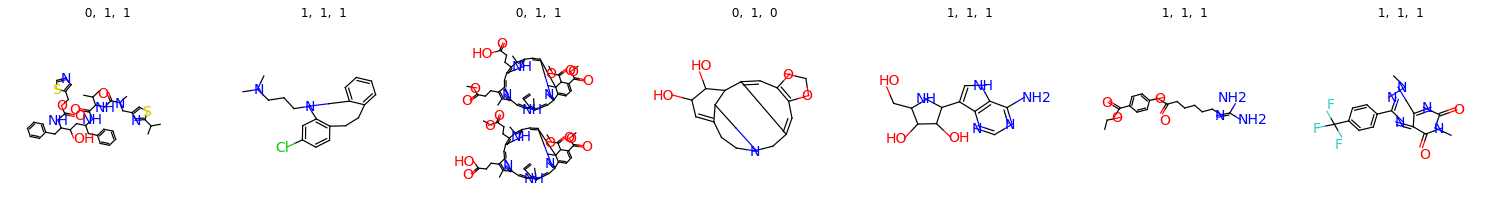

In [66]:
graphs = []
labels = []
print(false)
for i in false:
    print(final_result[i])
    sample = dataset0[i]
    graphs.append(sample.pop("graph"))
    label = [" %d" %  v for k, v in sample.items()]
    label = ", ".join(label)
    labels.append(label)
graph = data.Molecule.pack(graphs)
graph.visualize(labels, num_row=1)

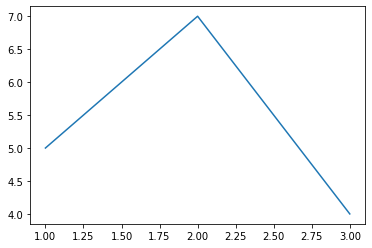

In [1]:
import matplotlib.pyplot as plt
plt.plot([1,2,3],[5,7,4])
plt.show()